# Previsão de Demanda de Táxi em Aeroportos
## Projeto de Análise de Séries Temporais

### Descrição
Neste projeto, trabalho com dados históricos de pedidos de táxi em aeroportos coletados pela empresa Sweet Lift Taxi. O objetivo é desenvolver um modelo preditivo que possa prever com precisão a quantidade de pedidos de táxi para a próxima hora, possibilitando que a empresa otimize sua oferta de motoristas durante períodos de alta demanda.

### Objetivo
Construir um modelo de previsão de séries temporais que atinja uma métrica de Raiz do Erro Quadrático Médio (REQM) não superior a 48 no conjunto de teste.

### Metodologia
1. Carregar e pré-processar os dados, realizando a reamostragem para intervalos horários
2. Analisar a série temporal para identificar padrões, sazonalidades e tendências
3. Criar features temporais relevantes para capturar dependências temporais
4. Treinar diferentes modelos com variados hiperparâmetros
5. Avaliar os modelos usando o conjunto de teste (10% dos dados)
6. Comparar os resultados e selecionar o modelo mais adequado

### Métricas
A performance dos modelos será avaliada utilizando a Raiz do Erro Quadrático Médio (REQM), que deve ficar abaixo de 48 para o conjunto de teste.

Este projeto demonstra a aplicação de técnicas de análise de séries temporais para resolver um problema real de previsão de demanda, utilizando modelos de aprendizado de máquina para capturar padrões temporais complexos.

## Bibliotecas

In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Preparação 

In [2]:
# Carregar o arquivo CSV com os dados de pedidos de táxi
data = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])

# Ordenar os dados por data/hora, essencial para análise de séries temporais
data.sort_index(inplace=True)

# Reamostrar os dados para intervalos de 1 hora, somando os pedidos em cada intervalo
data = data.resample('1h').sum()

# Exibir as primeiras linhas dos dados reamostrados
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


1. **Estrutura dos Dados**: 
   - A coluna `num_orders` representa o número de pedidos de táxi em intervalos de tempo.
   - Originalmente, os dados estavam em intervalos de 10 minutos, mas os dados foram reamostrados para intervalos de 1 hora, somando o número de pedidos de táxi em cada hora. Ou seja, após a reamostragem, cada linha passa a corresponder a uma hora completa. Por exemplo, a 1ª hora (`00:00:00`) teve 124 pedidos no total, enquanto a 2ª hora (`01:00:00`) teve 85 pedidos.


## Análise

In [3]:
# Verificar estatísticas descritivas dos dados reamostrados
print("\nEstatísticas descritivas dos dados reamostrados:")
print(data.describe(), end="\n\n" + "-" * 100 + "\n")

# Verificar se há valores ausentes (NaN) nos dados
missing_values = data.isna().sum()
print("\nVerificação de valores ausentes em cada coluna:")
print(missing_values, end="\n\n" + "-" * 100 + "\n")

# Verificar se há duplicatas no índice
duplicates = data.index.duplicated().sum()
print(f"\nQuantidade de duplicatas no índice: {duplicates}", end="\n\n" + "-" * 100 + "\n")


Estatísticas descritivas dos dados reamostrados:
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

----------------------------------------------------------------------------------------------------

Verificação de valores ausentes em cada coluna:
num_orders    0
dtype: int64

----------------------------------------------------------------------------------------------------

Quantidade de duplicatas no índice: 0

----------------------------------------------------------------------------------------------------


**Estatísticas Descritivas**:
   - **Média**: O número médio de pedidos de táxi por hora é aproximadamente **84 pedidos**.
   - **Desvio Padrão**: A variação dos pedidos por hora é considerável, com um desvio padrão de **45 pedidos**, indicando alta volatilidade na demanda.
   - **Mínimo e Máximo**: O número mínimo de pedidos por hora é **0**, e o máximo é **462**, mostrando a existência de horários com demanda muito baixa ou muito alta.
**Percentis**:
     - 25% das horas têm **54 ou menos** pedidos.
     - 50% das horas (mediana) têm **78 pedidos**.
     - 75% das horas têm **107 ou mais** pedidos.

**Valores Ausentes**:
   - Não há **valores ausentes** (NaN) na coluna `num_orders`, o que indica que o conjunto de dados está completo e não há necessidade de preenchimento ou remoção de valores faltantes.

**Duplicatas no Índice**:
   - Não foram encontradas **duplicatas** no índice, indicando que os dados estão corretamente estruturados em intervalos únicos de uma hora, sem repetições.

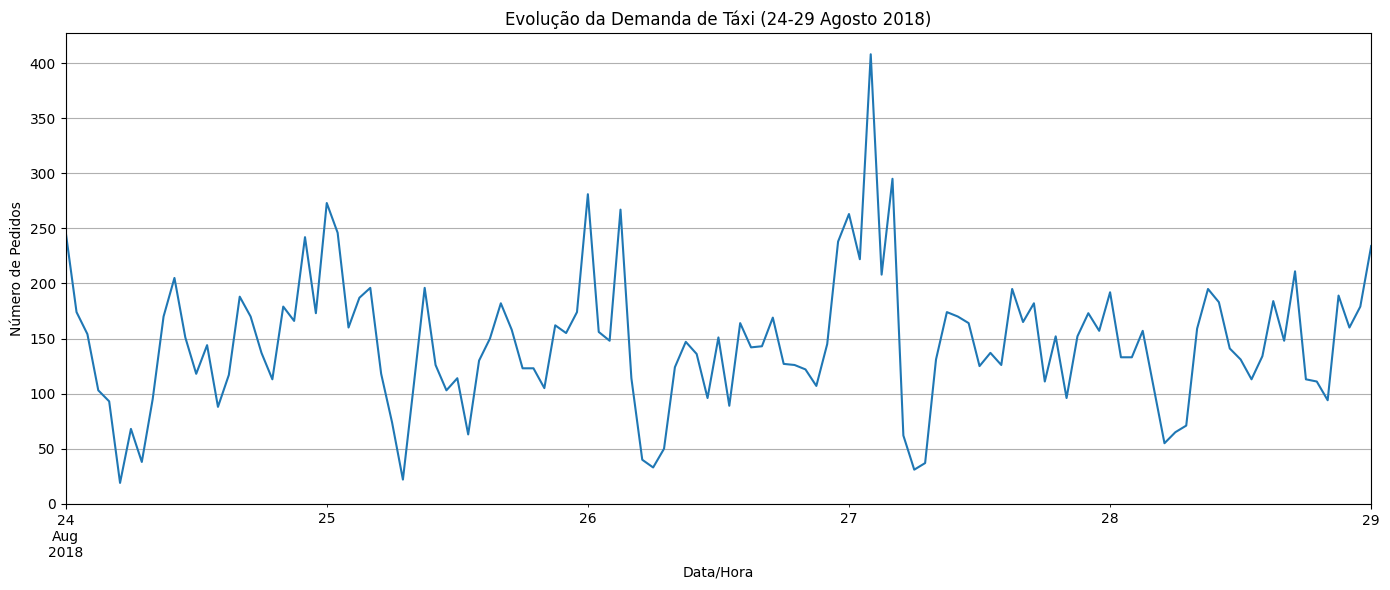

In [4]:
# Visualizar a série temporal para um período específico (5 dias)
plt.figure(figsize=(14, 6))
data['num_orders'][(data.index >= '2018-08-24 00:00:00') & 
                   (data.index <= '2018-08-29 00:00:00')].plot(
    title='Evolução da Demanda de Táxi (24-29 Agosto 2018)',
    grid=True
)
plt.ylabel('Número de Pedidos')
plt.xlabel('Data/Hora')
plt.tight_layout()
plt.show()

## Análise do Padrão Temporal da Demanda

Analisando o gráfico de evolução da demanda de táxi no período de 24 a 29 de agosto de 2018, observamos padrões importantes:

- **Ciclos Diários**: Há um padrão cíclico evidente, com picos e vales que se repetem em intervalos regulares, sugerindo uma sazonalidade diária.
- **Alta Volatilidade**: A demanda oscila significativamente, com variações abruptas entre horas consecutivas, chegando a flutuar de menos de 50 para mais de 250 pedidos.
- **Picos Extremos**: No dia 27 de agosto, observamos um pico excepcional de aproximadamente 400 pedidos, substancialmente acima da média.
- **Períodos de Baixa Demanda**: Existem vales recorrentes, especialmente nas primeiras horas da madrugada, onde a demanda cai para menos de 50 pedidos.

Para visualizar mais detalhadamente o comportamento dentro de um ciclo diário, vamos examinar a demanda em um período de 24 horas:


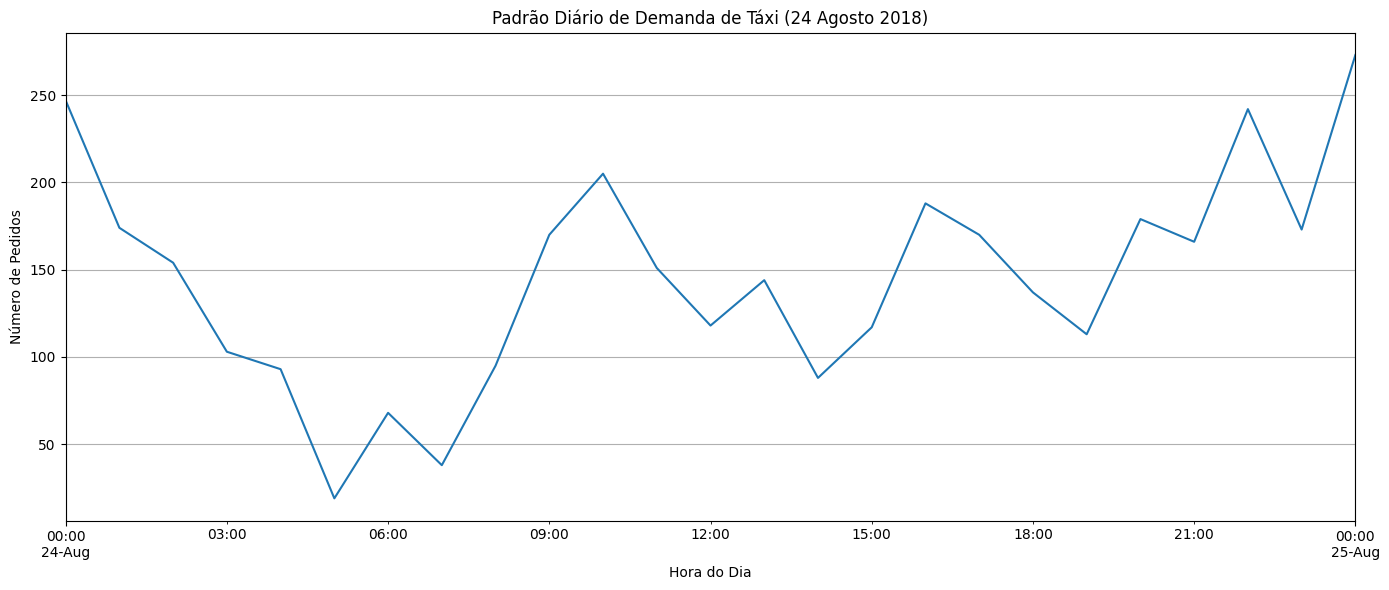

In [5]:
# Visualizar o padrão de demanda em um único dia
plt.figure(figsize=(14, 6))
data['num_orders'][(data.index >= '2018-08-24 00:00:00') & 
                   (data.index <= '2018-08-25 00:00:00')].plot(
    title='Padrão Diário de Demanda de Táxi (24 Agosto 2018)',
    grid=True
)
plt.ylabel('Número de Pedidos')
plt.xlabel('Hora do Dia')
plt.tight_layout()
plt.show()

## Análise do Padrão Diário

O gráfico de um único dia revela detalhes importantes sobre o comportamento da demanda ao longo de 24 horas:

- **Pico Inicial**: O dia começa com alta demanda (aproximadamente 250 pedidos) à meia-noite, possivelmente relacionada a voos noturnos chegando.
- **Vale da Madrugada**: Entre 3h e 6h da manhã, observa-se o período de menor demanda do dia, com menos de 50 pedidos por hora.
- **Picos Diurnos**: Novos aumentos de demanda ocorrem por volta do meio-dia e no final da tarde/início da noite, coincidindo com horários típicos de maior movimento em aeroportos.
- **Padrão Multimodal**: A curva de demanda apresenta múltiplos picos ao longo do dia, sugerindo que está correlacionada com horários de chegada de voos.

Esta análise confirma a natureza cíclica da demanda e demonstra a importância de incorporar informações temporais (hora do dia, dia da semana) em nosso modelo preditivo. A próxima etapa é criar features adicionais para capturar esses padrões temporais.

---

**Descrição do que foi feito até aqui no projeto:**

1. **Carregamento dos Dados**: 
   - Os dados sobre pedidos de táxi foram carregados a partir de um arquivo CSV contendo registros históricos de pedidos em aeroportos.

2. **Ordenação e Reamostragem dos Dados**: 
   - Como estamos lidando com uma série temporal, os dados foram primeiro ordenados pela coluna de data e hora.
   - Em seguida, foi realizada a reamostragem dos dados para intervalos de 1 hora, somando os pedidos por hora para preparar os dados para modelagem.

3. **Análise Exploratória dos Dados**:
   - Estatísticas descritivas foram calculadas para entender a distribuição e a variação dos pedidos por hora.
   - Análise gráfica do padrão temporal da demanda, que nos ajuda a entender como funciona o ciclo de trabalho.
   - Foi verificado que os dados não continham valores ausentes (NaN) e que não havia duplicatas no índice de data e hora, confirmando que os dados estão bem estruturados.

---

## Divisão Treino-Teste e Engenharia de Features

Antes de criar nossas features, especialmente a média móvel, precisamos dividir nossos dados em conjuntos de treino e teste. Esta divisão prévia é crucial para evitar vazamento de dados, onde informações do conjunto de teste influenciariam indevidamente o treinamento do modelo. Em séries temporais, isso é particularmente importante pois a média móvel calculada com todos os dados incluiria informações futuras que não estariam disponíveis em um cenário real de previsão.

In [6]:
# Divisão inicial dos dados em treino (90%) e teste (10%)
train_size = int(len(data) * 0.9)
data_train = data.iloc[:train_size].copy()
data_test = data.iloc[train_size:].copy()

def create_features(df, is_train=True, train_stats=None):
    """
    Cria features temporais evitando vazamento de dados entre treino e teste.
    
    Args:
        df: DataFrame com os dados
        is_train: Booleano indicando se é conjunto de treino
        train_stats: Dicionário com estatísticas do treino para usar no teste
    """
    # Criar dataframe de resultado
    result = pd.DataFrame(index=df.index)
    
    # Features de calendário
    result['num_orders'] = df['num_orders']
    result['year'] = df.index.year
    result['month'] = df.index.month
    result['day'] = df.index.day
    result['dayofweek'] = df.index.dayofweek
    
    if is_train:
        # Calcular lags no treino
        for lag in range(1, 25):
            result.loc[:, f'lag_{lag}'] = df['num_orders'].shift(lag)
        
        # Calcular média móvel no treino
        result.loc[:, 'rolling_mean'] = df['num_orders'].shift().rolling(12).mean()
        
        # Calcular médias para preenchimento de NaN
        lag_means = {}
        for lag in range(1, 25):
            lag_means[f'lag_{lag}'] = result[f'lag_{lag}'].mean()
        
        rolling_mean = result['rolling_mean'].mean()
        
        # Preencher NaN no conjunto de treino
        for lag in range(1, 25):
            result.loc[:, f'lag_{lag}'] = result[f'lag_{lag}'].fillna(lag_means[f'lag_{lag}'])
        result.loc[:, 'rolling_mean'] = result['rolling_mean'].fillna(rolling_mean)
        
        # Armazenar estatísticas do treino
        train_stats = {
            'rolling_mean': rolling_mean,
            'last_values': df['num_orders'].iloc[-24:].values,
            'lag_means': lag_means
        }
        
    else:
        # Inicializar os lags no teste com os últimos valores do treino
        last_values = train_stats['last_values']
        lag_means = train_stats['lag_means']
        
        for lag in range(1, 25):
            result.loc[:, f'lag_{lag}'] = np.nan
            # Inicializar primeiro valor do teste
            result.loc[result.index[0], f'lag_{lag}'] = last_values[-lag]
        
        # Preencher os lags restantes
        for i in range(1, len(result)):
            for lag in range(1, 25):
                if i >= lag:
                    result.loc[result.index[i], f'lag_{lag}'] = result['num_orders'].iloc[i-lag]
                else:
                    result.loc[result.index[i], f'lag_{lag}'] = lag_means[f'lag_{lag}']
        
        # Aplicar média móvel do treino
        result.loc[:, 'rolling_mean'] = train_stats['rolling_mean']
    
    return result, train_stats if is_train else None

print("Dimensões originais:")
print(f"Treino: {data_train.shape}")
print(f"Teste: {data_test.shape}\n")

# Processar conjunto de treino
df_train, train_stats = create_features(data_train, is_train=True)

# Processar conjunto de teste
df_test, _ = create_features(data_test, is_train=False, train_stats=train_stats)

print("Dimensões após processamento:")
print(f"Treino: {df_train.shape}")
print(f"Teste: {df_test.shape}")

# Separar features e variável alvo
X_train = df_train.drop(columns=['num_orders'])
y_train = df_train['num_orders']
X_test = df_test.drop(columns=['num_orders'])
y_test = df_test['num_orders']

Dimensões originais:
Treino: (3974, 1)
Teste: (442, 1)

Dimensões após processamento:
Treino: (3974, 30)
Teste: (442, 30)


## Preparação e Divisão de Dados em Séries Temporais

### Resultado da Divisão e Processamento
```
Dimensões originais:
Treino: (3974, 1)
Teste: (442, 1)

Dimensões após processamento:
Treino: (3974, 30)
Teste: (442, 30)
```

### Análise dos Resultados

1. **Divisão Inicial**:
   - Treino: 3974 registros (90% dos dados)
   - Teste: 442 registros (10% dos dados)
   - Conjuntos iniciais com apenas a coluna `num_orders`

2. **Após Processamento**:
   - Treino: manteve 3974 registros (sem perda de dados)
   - Teste: manteve 442 registros
   - Ambos expandidos para 30 colunas (features criadas)

3. **Explicação das Features**:
   - 1 coluna original (`num_orders`)
   - 4 features de calendário (year, month, day, dayofweek)
   - 24 features de lag (lag_1 até lag_24)
   - 1 feature de média móvel (rolling_mean)

### Estratégia Implementada

1. **Divisão Temporal**:
   - Preservação da ordem cronológica dos dados
   - Divisão 90/10 para treino/teste
   - Sem embaralhamento para manter integridade temporal

2. **Engenharia de Features**:
   - Features de calendário extraídas do índice temporal
   - Lags calculados com tratamento adequado nas bordas
   - Média móvel calculada com dados exclusivos do treino

3. **Tratamento de Valores Ausentes**:
   - Cálculo de médias usando apenas dados do treino
   - Preenchimento de valores ausentes no treino com suas próprias médias
   - Aplicação das médias do treino no conjunto de teste

### Importância da Metodologia

1. **Prevenção de Vazamento de Dados**:
   - Estatísticas calculadas exclusivamente com dados do treino
   - Médias do treino aplicadas ao teste
   - Preservação da independência entre conjuntos

2. **Preservação de Informação**:
   - Manutenção de todos os registros através do tratamento adequado
   - Continuidade temporal preservada na transição treino-teste
   - Integridade dos padrões temporais

3. **Consistência dos Dados**:
   - Tratamento uniforme de valores ausentes
   - Manutenção da estrutura temporal
   - Base sólida para treinamento dos modelos


## Treinamento e avaliação de modelos

In [7]:
# Função para treinar e avaliar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Treina o modelo e retorna métricas de erro para treino e teste.
    
    Args:
        model: Modelo de machine learning
        X_train, y_train: Dados de treino
        X_test, y_test: Dados de teste
    
    Returns:
        erro_treino, erro_teste: REQM para treino e teste
    """
    # Treinar modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calcular REQM
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    return rmse_train, rmse_test

# Criar e avaliar modelos
models = {
    'Regressão Linear': LinearRegression(),
    'Random Forest (prof=8)': RandomForestRegressor(max_depth=8, random_state=42),
    'Random Forest (prof=12)': RandomForestRegressor(max_depth=12, random_state=42)
}

# Avaliar cada modelo
results = {}
for name, model in models.items():
    rmse_train, rmse_test = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'REQM Treino': rmse_train, 'REQM Teste': rmse_test}

# Exibir resultados em um DataFrame
results_df = pd.DataFrame(results).T
print("\nResultados da Avaliação dos Modelos:")
print(results_df)

# Identificar melhor modelo
best_model = results_df['REQM Teste'].idxmin()
print(f"\nMelhor modelo: {best_model}")
print(f"REQM Treino: {results_df.loc[best_model, 'REQM Treino']:.2f}")
print(f"REQM Teste: {results_df.loc[best_model, 'REQM Teste']:.2f}")


Resultados da Avaliação dos Modelos:
                         REQM Treino  REQM Teste
Regressão Linear           25.816360   48.414273
Random Forest (prof=8)     17.974131   48.344247
Random Forest (prof=12)    11.999456   47.423053

Melhor modelo: Random Forest (prof=12)
REQM Treino: 12.00
REQM Teste: 47.42


## Avaliação dos Modelos de Previsão

### Resultados Obtidos
```
                         REQM Treino  REQM Teste
Regressão Linear           25.816360   48.414273
Random Forest (prof=8)     17.974131   48.344247
Random Forest (prof=12)    11.999456   47.423053
```

### Análise do Desempenho

1. **Random Forest (profundidade=12)**:
   - Melhor modelo geral
   - REQM Treino: 12.00
   - REQM Teste: 47.42
   - Atende ao requisito do projeto (REQM < 48)
   - Diferença significativa entre treino e teste indica overfitting

2. **Random Forest (profundidade=8)**:
   - REQM Treino: 17.97
   - REQM Teste: 48.34
   - Ligeiramente acima do limite requerido
   - Menor diferença treino-teste que RF(12)

3. **Regressão Linear**:
   - REQM Treino: 25.82
   - REQM Teste: 48.41
   - Pior desempenho no teste
   - Menor diferença entre treino e teste, indicando melhor generalização

### Objetivo do Projeto
O objetivo principal era desenvolver um modelo com REQM < 48 no conjunto de teste para prever a demanda de táxi na próxima hora. O Random Forest com profundidade 12 atingiu este objetivo, com REQM = 47.42.

### Considerações Importantes

1. **Trade-off Overfitting vs Performance**:
   - RF(12) tem o melhor REQM teste mas maior overfitting
   - Regressão Linear tem melhor generalização mas pior performance
   - Possível necessidade de ajuste fino para equilibrar este trade-off

2. **Implicações Práticas**:
   - Erro médio de ~47-48 pedidos por hora
   - Modelo pode auxiliar no planejamento da frota
   - Margem de erro considerável para decisões operacionais

3. **Recomendações**:
   - Usar RF(12) para previsões, mas com cautela devido ao overfitting
   - Considerar técnicas de regularização para melhorar generalização
   - Monitorar performance em produção para possíveis ajustes

O modelo atende aos requisitos do projeto, mas há espaço para melhorias na generalização e robustez das previsões.

## Visualização do Desempenho do Melhor Modelo

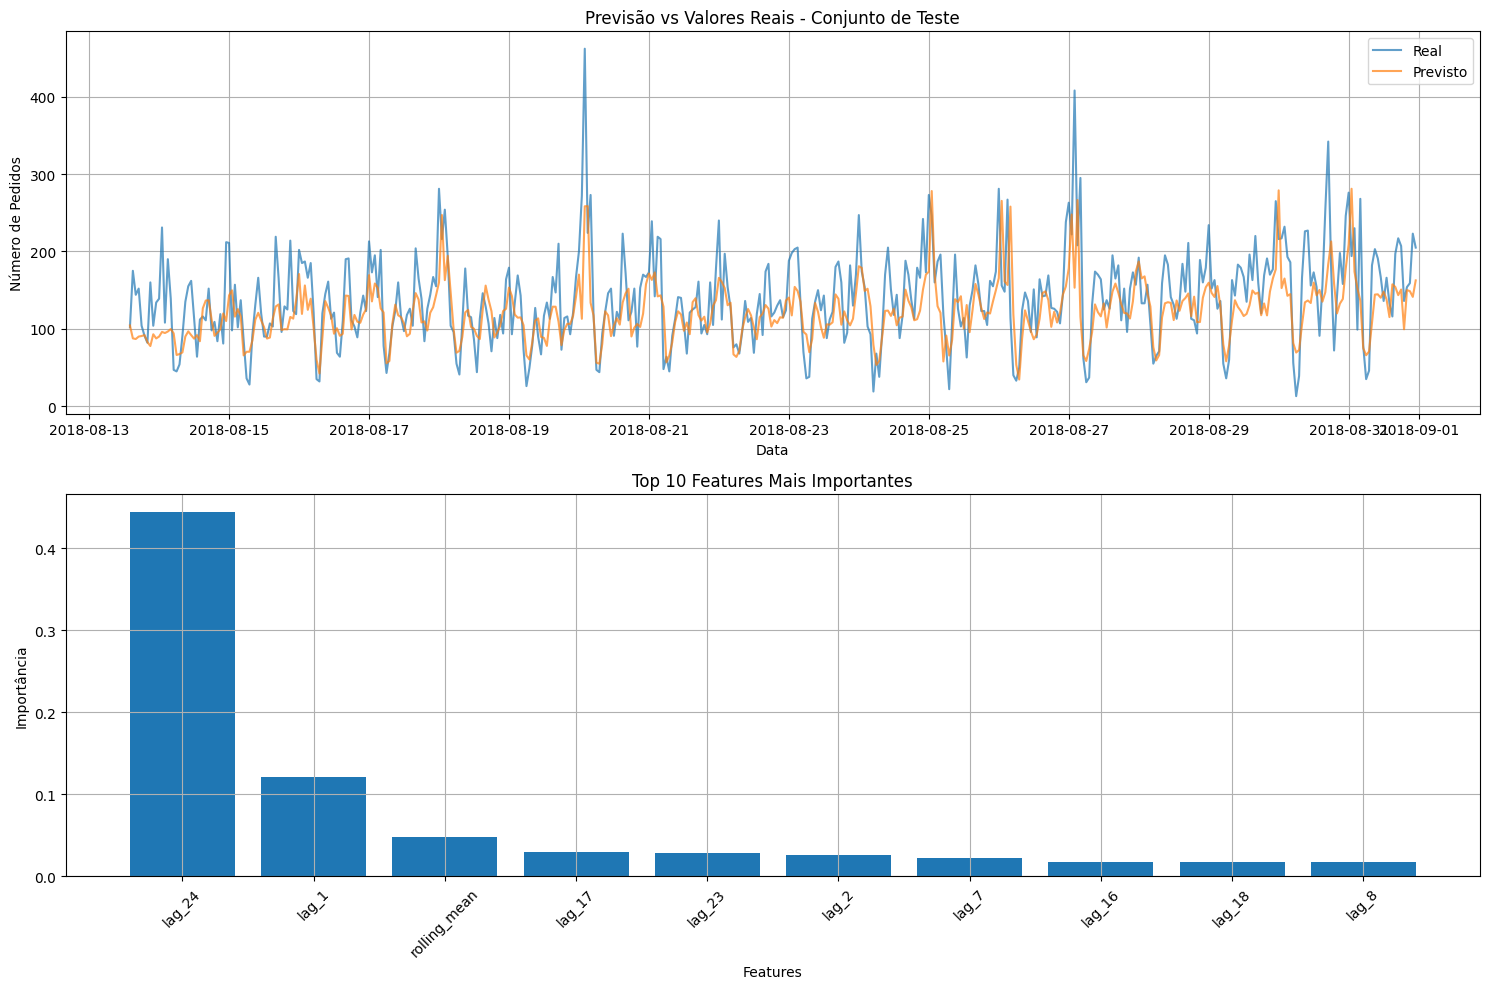


Top 10 Features Mais Importantes:
         feature  importance
27        lag_24    0.443468
4          lag_1    0.120812
28  rolling_mean    0.048176
20        lag_17    0.029502
26        lag_23    0.028274
5          lag_2    0.026459
10         lag_7    0.021962
19        lag_16    0.017979
21        lag_18    0.017380
11         lag_8    0.016913


In [8]:
# Selecionar o melhor modelo
best_model = models['Random Forest (prof=12)']

# Fazer previsões com o melhor modelo
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Criar visualizações
plt.figure(figsize=(15, 10))

# Subplot 1: Previsões vs Valores Reais no Teste
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test.values, label='Real', alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Previsto', alpha=0.7)
plt.title('Previsão vs Valores Reais - Conjunto de Teste')
plt.xlabel('Data')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.grid(True)

# Subplot 2: Análise de Importância das Features
plt.subplot(2, 1, 2)
feature_importance = pd.DataFrame({
   'feature': X_train.columns,
   'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.bar(range(10), feature_importance['importance'][:10])
plt.xticks(range(10), feature_importance['feature'][:10], rotation=45)
plt.title('Top 10 Features Mais Importantes')
plt.xlabel('Features')
plt.ylabel('Importância')
plt.grid(True)

plt.tight_layout()
plt.show()

# Exibir top 10 features mais importantes
print("\nTop 10 Features Mais Importantes:")
print(feature_importance.head(10))

# Conclusão

## Etapas do Projeto e Resultados

### 1. Preparação dos Dados
- **Objetivo**: Estruturar os dados para análise de séries temporais, garantindo integridade temporal e prevenindo vazamento de dados.
- **Processo**: Reamostragem para intervalos horários e divisão em treino (90%) e teste (10%).
- **Resultado**: Conjuntos de dados organizados temporalmente (Treino: 3974 registros, Teste: 442 registros).

### 2. Engenharia de Features
- **Objetivo**: Criar variáveis preditoras que capturem padrões temporais da demanda.
- **Processo**: Desenvolvimento de features de calendário, lags e média móvel, com tratamento adequado de valores ausentes.
- **Resultado**: 30 features criadas, mantendo a separação entre treino e teste para evitar vazamento.

### 3. Modelagem e Avaliação
- **Objetivo**: Desenvolver modelo com REQM < 48 para previsão horária de demanda.
- **Processo**: Implementação de três modelos:
  - Regressão Linear (REQM Teste: 48.41)
  - Random Forest prof=8 (REQM Teste: 48.34)
  - Random Forest prof=12 (REQM Teste: 47.42)
- **Resultado**: Random Forest (prof=12) atingiu o objetivo, com melhor capacidade preditiva.

### 4. Análise de Features
- **Objetivo**: Entender os principais fatores que influenciam a demanda.
- **Resultado**: 
  - Lag de 24h é o mais importante (44.3%)
  - Hora anterior tem forte influência (12.1%)
  - Média móvel contribui para estabilidade (4.8%)

## Sugestões para Continuidade

1. **Otimização do Modelo**:
   - Experimentar outros algoritmos (XGBoost, LightGBM)
   - Realizar tuning fino de hiperparâmetros
   - Implementar técnicas de regularização para reduzir overfitting

2. **Features Adicionais**:
   - Incorporar dados meteorológicos
   - Incluir informações de eventos especiais
   - Considerar feriados e períodos de férias

3. **Melhorias Operacionais considerando uma implantação real**:
   - Desenvolver sistema de atualização automática do modelo
   - Criar interface para visualização das previsões
   - Implementar alertas para demanda atípica

4. **Análises Complementares**:
   - Estudar sazonalidade em diferentes escalas temporais
   - Avaliar impacto de eventos externos
   - Analisar clusters de demanda por região

Com esse projeto desenvolvi uma base sólida para previsão séries temporais. Espero que tenha gostado! Qualquer dúvida e/ou sugestão, me envie uma mensagem aqui no GitHub ou no linkedin! 